# Kernel Learning And Its Application In Non-Linear Support Vector Machines

Sven Nekula (Otto-Friedrich-University Bamberg, sven-jason-waldemar.nekula@stud.uni-bamberg.de) <br />
Joshua Simon (Otto-Friedrich-University Bamberg, joshua-gunter.simon@stud.uni-bamberg.de) <br />
Anastasia Sinitsyna (Otto-Friedrich-University Bamberg, anastasia.sinitsyna@stud.uni-bamberg.de)

## Summary
In this notebook we discuss the application of kernel learning methods to non-linear support vector machines. Support vector machines (SVMs) are a set of supervised learning methods used for classification and regression. Starting with examples of linearly separable data in a problem space, we will explain the mathematical background to linear SVMs as binary classifiers and discuss limits. This motivates us to use the kernel trick to expand the concepts to non-linear SVMs in order to also classify more complex data examples. In addition to the use of well-known software libraries, this notebook also introduces and compares our own implementation of SVMs. Finally, there is a short overview of different kernels and their application in practical examples.

## Overview
* [1. Introduction](#1.-Introduction)
    * [1.1 Linearly separable data classes](#1.1-Linearly-separable-data-classes)
    * [1.2 Similarity and linear algebra](#1.2-Similarity-and-linear-algebra)
    * [1.3 Hyperplane classifiers: Solving an optimization problem](#1.3-Hyperplane-classifiers:-Solving-an-optimization-problem)
* [2. Linear SVMs](#2.-Linear-SVMs)
    * [2.1 Maximum margin separator](#2.1-Maximum-margin-seperator)
    * [2.2 Limitations](#2.2-Limitations)
* [3. Non-linear SVMs](#3.-Non-linear-SVMs)
    * [3.1 The kernel trick](#3.1-The-kernel-trick)
    * [3.2 Solving a non-linearly separable classification problem](#3.2-Solving-a-non-linearly-separable-classification-problem)
    * [3.3 A closer look at kernels](#3.3-A-closer-look-at-kernels)
* [4. More kernel applications](#4.-More-kernel-applications)
* [5. Conclusion](#5.-Conclusion)

## Python modules

In [46]:
import numpy as np
import warnings

from time import time

from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits import mplot3d
%matplotlib inline

## Helper functions

This section contains functions that are not directly related to our topic or fulfill a more general purpose.

In [2]:
def plot_2D(X, y, legend=False):
    """ 
    Standard 2D scatter plot. 
    -----------
    Parameters:
    - X: matrix with (x1, x2) data points
    - y: vector with color labels for individual points
    - legend(default = False): if true, legend for labels is shown
    -----------
    """
    # Map labels to -1 and + 1.
    y = np.where(y == 0, -1, y)
    
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y)
    
    if legend:
        plt.legend(*scatter.legend_elements(),
                    loc="upper left", title="Labels")
    

def plot_2D_svm(model):
    """ 
    Draws the decision boundary/margin of a svm model by 
    estimating more data points of the grid and marks the 
    support vectors of the passed svm model.
    -----------
    Parameters:
    - model: sklearn.svm.SVC() model object
    -----------
    """
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Estimate decision boundary.
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)

    # Plot decision boundary/margin.
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # Plot support vectors.
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k', 
               label="Support Vectors")


def plot_3D(X, y, z, elev=30, azim=30):
    """ 
    Plots rotatable 3D scatter plot with scaled z-axis. 
    -----------
    Parameters:
    - X: matrix with (x1, x2) data points
    - y: vector with color labels for individual points
    - z: vector with scale levels for individual points
    - elev, azim: view angles
    -----------
    """
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], z, c=y, s=50)
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.set_zlabel(r"$z$")

# 1. Introduction

## 1.1 Linearly separable data classes
First, let's consider a given data set $\mathcal{X}$ of labeled points (inputs) with individual labels $y_i \in \left\{ -1,1 \right\}$, e.g. $(x_1,y_1), ..., (x_m, y_m) \in \mathcal{X} \times \left\{ -1,1 \right\}$. Our goal is to implement a classification method, which is able to classify new and unlabeld data points with the right or "best" label. In machine learning, a well established classification method are the so called __Support Vector Machines__ (SVM). Developed by Vladimir Vapnik and his coworkers in the 1990s, SVMs are still a relevant topic and an even more powerful tool for __classification__ and __regression__.

The following example shows a data set $\mathcal{X}$, which is linearly separable. By that we mean, that the labeled data can be separated by a straight line, so that each point with label $-1$ is on one side of the line and each point with label $1$ on the other side. The `make_blobs` function from the `sklearn.datasets` module can be used to generate some example data. The wrapper function `plot_2D` is used to draw a scatter plot of the generated data.

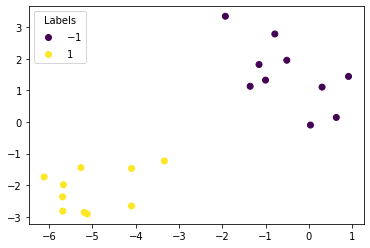

In [3]:
X, y = make_blobs(n_samples=20, centers=2, center_box=(-5.0, 5.0), random_state=1)
plot_2D(X, y, legend=True)

## 1.2 Similarity and linear algebra

We now will briefly discuss similarity and some core concepts of linear algebra.

### Similarity
To perform a classification, a similarity measure is needed. Finding a suitable measure is a core problem of machine learning. For now let's consider


\begin{equation}
    \begin{aligned}
        k: \mathcal{X} \times \mathcal{X} & \rightarrow \mathbb{R} \\
        (x, x') & \mapsto k(x, x')
    \end{aligned}
\label{eq:kernel} \tag{1}
\end{equation}


where $k$ is a function that, given to patterns $x$ and $x'$, returns a real number characterizing their similarity. 
This function $k$ is called a **kernel**. Unless stated otherwise, $k(x, x') = k(x', x)$.

### Dot product and vector norm
A simple type of similarity measure is a **dot product**. Given two vectors $x, x' \in \mathbb{R}^m$ the canonical dot product is defined as

\begin{equation}
    \langle x,x' \rangle = (x')^T x = \sum_{i = 1}^{m} [x]_i [x']_i,
\label{eq:dotproduct} \tag{2}
\end{equation}

where $\left[x\right]_i$ denotes the $i$th entry of $x$. Futhermore this allows a calculation of the **norm** (length) of a single vector $x$ as

\begin{equation}
    \left\lVert x \right\rVert = \sqrt{\langle x,x \rangle}.
\label{eq:nrom} \tag{3}
\end{equation}

Given a vector space $\mathcal{V}$ (mostly over $\mathbb{R}$ or $\mathbb{C}$) and a dot product, one can define a so called **dot product space** or **Pre-Hilbert space** $\mathcal{H}$, where every pair of elements $x, x' \in \mathcal{V}$ is assigned to a scalar value, the dot product of $x$ and $x'$ [[Bronstein, 2020]](#Bronstein).

More properties of vector spaces, dot products and norms can be found in [[Liesen, 2015]](#Liesen).



### Hyperplanes

A __hyperplane__ is a subspace $S$ whose dimension is one less than that of its surrounding space $X$ 

\begin{equation*}
    dim(S) = dim(X) - 1.
\end{equation*}

Here, $X$ is our problem space, so $X = \mathcal{X}$. In Cartesian coordinates, such a hyperplane can be described with a single linear equation of the following form 

\begin{equation*}
    w_1 x_1 + w_2 x_2 + \dots + w_m x_m = b,
\end{equation*}

where at least one $w_i$ is non-zero and $x_i, w_i, b \in \mathbb{R}$. So a hyperplane in a three-dimensional problem space $\mathcal{X}$ has dimension $dim(S) = 2$ and the shape of a plane. In a two-dimensional problem space, the shape of the hyperplane results as a straight line with $dim(S) = 1$.

## 1.3 Hyperplane classifiers: Solving an optimization problem

The underlying learning algorithm of SVMs yields to find a hyperplane in some dot product space $\mathcal{H}$, which separates the data. A hyperplane of the form

\begin{equation}
    \langle w,x \rangle + b = 0
\label{eq:hyperplane} \tag{4}
\end{equation}

where $w \in \mathcal{H}, b \in \mathbb{R}$ shall be considered [[Schölkopf, 2002]](#Schölkopf). Here, $w$ is a weight vector, which can be seen as the normal vector of the hyperplane, while $b$ is a bias correcting the offset from the origin. Futhermore decision functions

\begin{equation}
    f(x) = sgn \left( \langle w,x \rangle + b \right)
\label{eq:decfun1} \tag{5}
\end{equation}
    
can be assigned. By passing the hyperplane equation as an argument to the sign function $sgn(\cdot)$, $f(x)$ will return $-1$ if the input $x$ is on one side of the hyperplane and $1$ if the input is on the other side.

As the data from our introductory example suggests, there are several solutions for such a hyperplane. The next figure shows three possible hyperplanes, each of which separates the data set in a linear manner. 

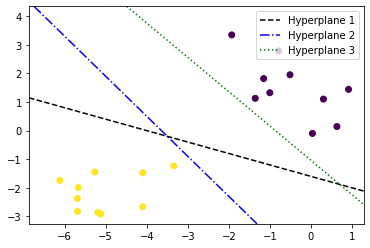

In [4]:
plot_2D(X, y)
plt.axline((-6.5, 1.0), slope=-0.4, linestyle='--', color='black', label='Hyperplane 1')
plt.axline((-6.5, 4.0), slope=-1.4, linestyle='-.', color='blue', label='Hyperplane 2')
plt.axline((-4.2, 4.0), slope=-1.2, linestyle=':', color='green', label='Hyperplane 3')
plt.legend()

This begs the question of whether one can find an optimal hyperplane that has the best classification properties. In the next steps, we will make use of the mathematical optimization theory and introduce a toolchain of procedures that allow us to calculate the best possible hyperplane.

### A contrained optimization problem
The **optimal hyperplane** can be calculated by finding the normal vector $w$ that leads to the largest margin. Thus we need to solve the optimization problem

\begin{equation}
    \begin{aligned}
        \min_{w \in \mathcal{H}, b \in \mathbb{R}} \quad & \tau (w) = \frac{1}{2} \lVert w \rVert^2 \\
        \textrm{subject to} \quad & y_{i} \left( \langle w,x \rangle + b \right) \geq 1 \text{ } \forall i = {1, \dots, m}. 
    \end{aligned}
\label{eq:objfun} \tag{6}
\end{equation}

The constraints in $\eqref{eq:objfun}$ ensure that $f(x_i)$ will be $+1$ for $y_i = +1$ and $-1$ for  $y_i = -1$. The $\geq 1$ on the right hand side of the constraints effectively fixes the scaling of $w$. This leads to the maximum margin hyperplane. A detailed explanation can be found in [[Schölkopf, 2002]](#Schölkopf). The problem in $\eqref{eq:objfun}$ is also called a contrained optimization problem. We will also refer to this problem as our __primal__ problem with the __primal variables__ $w$ and $b$.

### Lagrangian
The constrained optimization problem in $\eqref{eq:objfun}$ can be re-written using the method of __Lagrange multipliers__. This leads to the Lagrangian

\begin{equation}
    L(w,b,\alpha) = \frac{1}{2} \lVert w \rVert^2 - \sum_{i=1}^{m} \alpha_i \left( y_{i} 
    \left( \langle w,x \rangle + b \right) - 1 \right)\\
    \textrm{subject to} \quad \alpha_i \geq 0 \text{ } \forall i = {1, \dots, m}.
\label{eq:Lagrangian} \tag{7}
\end{equation}

Here, $\alpha_i$ are the Lagrange multipliers. The Lagrangian $L$ has to be minimized with respect to the primal variables $w$ and $b$ and maximized with respect to the dual variables $\alpha_i$ (in other words, a saddle point has to be found).

### KKT conditions
The __Karush-Kuhn-Tucker (KKT)__ complementarity conditions of optimization theory state, that at the saddle point, the derivatives of $L$ with respect to the primal variables must vanish, so

\begin{equation}
    \frac{\partial}{\partial b} L(w,b,\alpha) = 0 \text{ and } \frac{\partial}{\partial w} L(w,b,\alpha) = 0
\label{eq:KKT} \tag{8}
\end{equation}

leads to

\begin{equation}
    \sum_{i=1}^{m} \alpha_i y_i = 0 \text{ and } w = \sum_{i=1}^{m} \alpha_i y_i x_i.
\label{eq:KKT2} \tag{9}
\end{equation}

The solution vector $w$ thus has an expansion in terms of a subset of the training patterns, namely those patterns with non-zero $\alpha_i$, called Support Vectors (SVs).

### Dual optimization problem
We can again re-write our optimization problem by substituting $\eqref{eq:KKT2}$ into the Lagrangian $\eqref{eq:Lagrangian}$ to eliminate the primal variables. This yields the dual optimization problem, which is usually solved in practice

\begin{equation}
    \begin{aligned}
            \max_{\alpha \in \mathbb{R}^m} \quad & W(\alpha) = \sum_{i=1}^{m} \alpha_i - \frac{1}{2} \sum_{i,j=1}^{m} \alpha_i 
            \alpha_j y_i y_j \langle x_i,x_j \rangle \\
            \textrm{subject to} \quad & \alpha_i \geq 0 \text{ } \forall i = {1, \dots, m} \text{ and } \sum_{i=1}^{m} 
            \alpha_i y_i = 0. 
    \end{aligned}
\label{eq:DuOpPr} \tag{10}
\end{equation}

The dual optimization problem $\eqref{eq:DuOpPr}$ is a **convex quadratic programming problem** and therefore can be solved by using standard optimization techniques. 

Finally, the decision function can be re-written using $\eqref{eq:KKT2}$ as

<a id="eq_11"></a>

\begin{equation}
    f(x) = sgn \left( \sum_{i=1}^{m} \alpha_i y_i \langle x,x_i \rangle + b \right),
\label{eq:decfun2} \tag{11}
\end{equation}

where $b$ can be computed by exploiting $\alpha_i \left[ y_i \left( \langle x_i,w \rangle + b \right) - 1 \right] = 0$, which follows from the KKT conditions.


Details on mathematical optimization and convex constrained problems can be found in [[Jarre, 2019]](#Jarre). Explanations on dealing with non-linear problems are given in [[Reinhardt, 2012]](#Reinhardt).

# 2. Linear SVMs

This section deals with the application of linear support vector machines on different data examples and shows some limitations of the linear approach. Later soft margin classifier are introduced to show a tool, that can handle some more problems and has a greater relevance in real life applications. However, we will see the limits of the method when only using a linear SVM.

## 2.1 Maximum margin seperator
We now have all the theoretical background to go back to our inital classification problem. We can implement a SVM as a maximum margin separator for the given data set $\mathcal{X}$. Since our similarity measure $k(x, x_i)$ is expressed only through the canonical dot product $\langle x, x_i \rangle$, our kernel is called a __linear kernel__. Thus we speak of linear SVMs in this section.

The following example uses the `sklearn.svm` implementation to create the model as a support vector classifier `SVC()` and the `fit()` method to train the model with our generated example data. In the model initialization, the `kernel` argument can be set to `'linear'`to apply the linear kernel. Here, `X`is a matrix containing the coordinates of our input patterns and `y`a vector containing the label information. After that, the data is plotted again with `plot_2D()` and the support vectors and decision boundary/margin are added to the figure by calling `plot_2D_svm()`. The support vectors are marked with a circle around the data point.

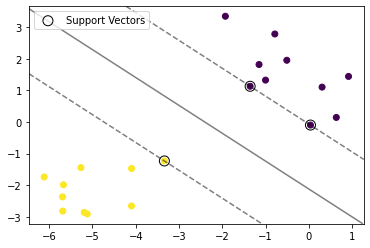

In [5]:
# Creating/fitting the model.
model_linear = svm.SVC(kernel='linear')
model_linear.fit(X, y)

# Plot the fit for the given example.
plot_2D(X, y, legend=False)
plot_2D_svm(model_linear)
plt.legend(loc="upper left")

## 2.2 Limitations
Let's consider following data set.

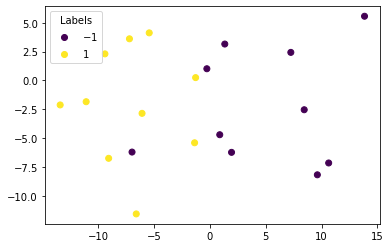

In [6]:
X, y = make_blobs(n_samples=20, centers=2, cluster_std = 4.5 ,random_state=123)
plot_2D(X, y, legend=True)

As one can easily see, it is now much more difficult to find a separating linear hyperplane for these type of data. However, by allowing our classifier to make some 'mistakes' and therefore soften the optimazation constraints, we shall find a hyperplane for separating the data. This concept is called soft margin hyperplanes or soft margin separator/classifier and is introduced in the following section.

### Soft Margin Hyperplanes
We introduce a slack variable

\begin{equation}
    \xi_{ i } \geq 0 \text{ } \forall i = {1, \dots, m}
\label{eq:Xi} \tag{12}
\end{equation}

in the simplest case, this leads to 

\begin{equation}
    \begin{aligned}
        \min_{w \in \mathcal{H}, \xi \in \mathbb{R}^{n}} \quad & \tau (w, \xi) = \frac{1}{2} \lVert w \rVert^2 + 
        \frac{C}{m} 
        \sum_{i=1}^{m} \xi_{i} \\
        \textrm{subject to} \quad & y_{i} \left( \langle w,x \rangle + b \right) \geq 1 - \xi_{i} \text{ } 
        \forall i = {1, \dots, m}. 
    \end{aligned}
\label{eq:objfun2} \tag{13}
\end{equation}

By making $\xi_{i}$ large enough, the constraint can always be met, which is why we penalize them in the objective function with $\frac{C}{m}$, where $C \in \mathbb{R}$ is a regularization parameter.

Our dual optimization problem also gets re-written as

\begin{equation}
    \begin{aligned}
        \max_{\alpha \in \mathbb{R}^m} \quad & W(\alpha) = \sum_{i=1}^{m} \alpha_i - \frac{1}{2} \sum_{i,j=1}^{m} \alpha_i 
        \alpha_j y_i y_j \langle x_i,x_j \rangle \\
        \textrm{subject to} \quad & 0 \leq \alpha_i \leq \frac{C}{m} \text{ } \forall i = {1, \dots, m} \text{ and } 
        \sum_{i=1}^{m} \alpha_i y_i = 0. 
    \end{aligned}
\label{eq:DuOpPr2} \tag{14}
\end{equation}

This classifier is referred to as C-SV classifier and can be used to prevent overfitting by allowing the classifier to make false classifications. More classifiers using soft margins can be found in [[Schölkopf, 2002]](#Schölkopf). 

The following example shows the influence of $C$ on the hyperplane and its margin. For this the `sklearn.svm.SVC()` class can still be used by specifying the `C` parameter in the initialization of the model object. The strength of the regularization is inversely proportional to `C` (see <https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/svm/_classes.py>).  The runtime of the calculation will increase, when `C` becomes big.

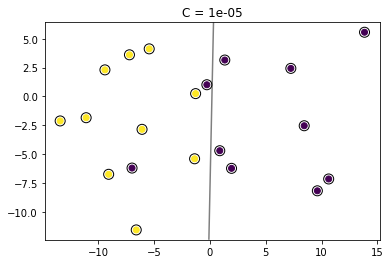

Number of support vectors: 20, C = 1e-05


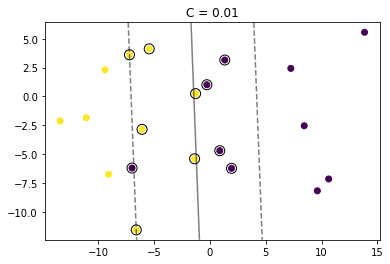

Number of support vectors: 11, C = 0.01


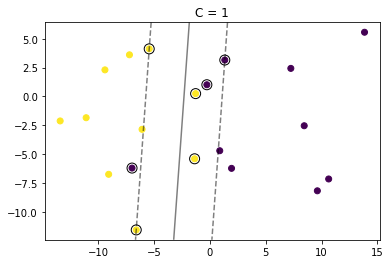

Number of support vectors: 7, C = 1


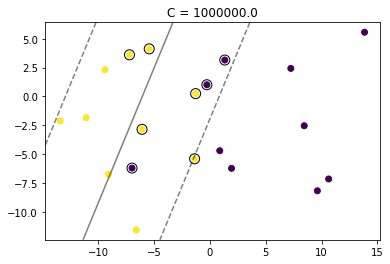

Number of support vectors: 8, C = 1000000.0


In [7]:
C = [0.00001, 0.01, 1, 1e6]

for c in C:
    model_slack = svm.SVC(kernel='linear', C=c)
    model_slack.fit(X, y)

    plot_2D(X, y)
    plot_2D_svm(model_slack)
    plt.title(f"C = {c}")
    plt.show()

    print(f"Number of support vectors: {len(model_slack.support_vectors_[:, 0])}, C = {c}")

We can see, that we can get acceptable results using the soft margin hyperplane classifier. The key is to find a suitable regularization parameter $C$. This is often one of the hardest tasks, since a priori estimations for $C$ can not be made. To find a satisfying $C$, techniques like cross validation can be used.

Even though we have now found a valuable tool in soft margins, there are a number of problems in practice that cannot be solved with this alone. Let's consider following data sets.

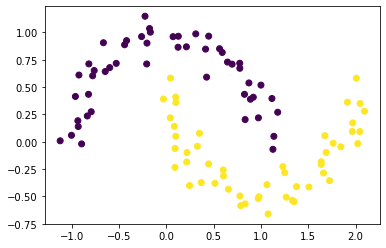

In [8]:
X_moon, y_moon = make_moons(n_samples = 100, noise = 0.1, random_state = 123)
plot_2D(X_moon, y_moon)

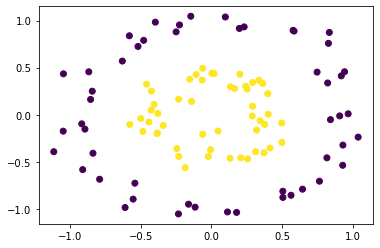

In [9]:
X_circle, y_circle = make_circles(n_samples = 100, factor = 0.4, noise = 0.1, random_state = 321)
plot_2D(X_circle, y_circle)

If we try to separate this data with our previous methods, we quickly come up against limits. It is easy to see that such predictions cannot be used. 

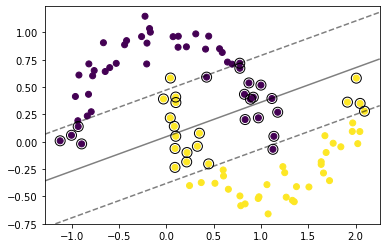

In [10]:
lin_model_moon = svm.SVC(kernel='linear')
lin_model_moon.fit(X_moon, y_moon)

plot_2D(X_moon, y_moon)
plot_2D_svm(lin_model_moon)

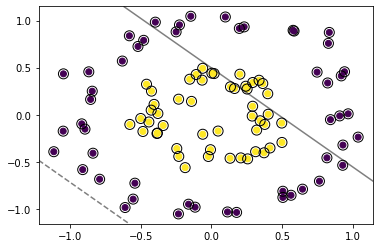

In [11]:
lin_model_circle = svm.SVC(kernel='linear')
lin_model_circle.fit(X_circle, y_circle)

plot_2D(X_circle, y_circle)
plot_2D_svm(lin_model_circle)

# 3. Non-linear SVMs

As seen before, there can be plenty of problems, which can not be separated well with the linear kernel. This section will cover a mathematical trick, that can be used to implicitly transform your given dataset $\mathcal{X}$ to a different dot product space with a higher dimension. In this space, our dataset will again become linearly separable.

## 3.1 The kernel trick
To extend the introduced SVM algorithm, we can substitute ([11](#eq_11)) by applying a kernel of the form

\begin{equation}
    k(x,x') = \langle \Phi (x), \Phi (x') \rangle
\tag{15}
\end{equation}

where 

\begin{equation}
    \begin{aligned}
        \Phi: \mathcal{X} & \rightarrow \mathcal{H} \\
        (x) & \mapsto \Phi (x)
    \end{aligned}
\tag{16}
\end{equation}

is a function that maps an input from $ \mathcal{X} $ into a dot product space $ \mathcal{H} $. This is referred to as the **kernel trick**. We then obtain decision functions of the form

\begin{equation}
    f(x) = sgn \left( \sum_{i=1}^{m} \alpha_i y_i \langle \Phi (x), \Phi (x_i) \rangle + b \right) \\ 
    = sgn \left( \sum_{i=1}^{m} \alpha_i y_i k(x,x_i) + b \right)
\tag{17}
\end{equation}

and the optimization problem

<a id="eq_kernel_dual"></a>

\begin{equation} \label{eq:6}
    \begin{aligned}
            \max_{\alpha \in \mathbb{R}^m} \quad & W(\alpha) = \sum_{i=1}^{m} \alpha_i - \frac{1}{2} \sum_{i,j=1}^{m} 
            \alpha_i \alpha_j y_i y_j k(x_i, x_j) \\
            \textrm{subject to} \quad & \alpha_i \geq 0 \text{ } \forall i = {1, \dots, m} \text{ and } \sum_{i=1}^{m} 
            \alpha_i y_i = 0. 
    \end{aligned}
\tag{18}
\end{equation}

This enables us to operate in a high-dimensional, implicit feature space without ever computing the coordinates of the data $\mathcal{X}$ in that space, but rather by simply computing the dot products or kernel representations $k(x_i, x_j)$ between the images of all pairs of data in the feature space. This operation is often computationally cheaper than the explicit computation of the coordinates __[wiki, kernel]__. So we do not need to calculate the map function $\Phi(x)$ to transform our inputs $x$. The $m \times m$ Matrix $K$ with elements $K_{ij} = k(x_i, x_j)$ is called the **Gram matrix** (or kernel matrix) of $k$. A kernel $k$ is called **positive definite kernel** when the Gram matrix $K$ is positive definite. 

As stated in [[Schölkopf, 2002]](#Schölkopf): _"Given an algorithm which is formulated in terms of a positive definite kernel $k$, one can construct an alternative algorithm by replacing $k$ by another positive definite kernel $\tilde{k}$"_. The kernel trick can be applied since all feature vectors only occurred in dot products. A more precise explanation can be found in [[Schölkopf, 2002]](#Schölkopf).

## 3.2 Solving a non-linearly separable classification problem

### A suitable kernel
Going back to our problem of non-linearly separable data, we can use a kernel function of the form

\begin{equation}
    k(x, x') = \exp \left( - \frac{\left\lVert x - x' \right\rVert^2}{2 \sigma^2} \right),
\tag{19}
\end{equation}

a so called __Gaussian radial basis function__ (GRBF or RBF kernels) with $ \sigma > 0$.

In [12]:
def rbf(X, sigma=1):
    """ Radial basis function for scaling data in 3rd dimension. """
    return np.exp(-(X ** 2).sum(1) / (2 * sigma))

Each of the two following examples shows the mapping of the data from our two-dimensional problem space to a higher-dimensional feature space in the first plot. Here, the latter is a three-dimensional space. The mapping is calculated by evaluating the `rbf()` function for $ \mathcal{X} $ with `sigma=np.var(X)`, which returns the variance of $ \mathcal{X} $. The `plot_3D()` function is used to draw a three-dimensional scatter plot of the scaled data. 

We then create our non-linear model using the `sklearn.svm.SVC()` class by passing `kernel='rbf'` to the constructor. In the second plot, the corresponding separating hyperplane in the original problem space is shown. One can see, that the hyperplane now becomes a non-linear curve. We will call this type of support vector machines non-linear SVMs.

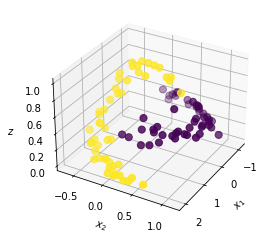

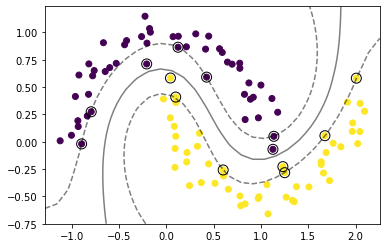

In [13]:
# Example 1:
# Plot the data in a higher-dimensional space.
plot_3D(X=X_moon, y=y_moon, z=rbf(X_moon, np.var(X_moon)))
plt.show()

# Create and fit the non-linear model using the 'rbf' kernel.
non_lin_model_moon = svm.SVC(kernel='rbf', C=10)
non_lin_model_moon.fit(X_moon, y_moon)

# Plot the separating hyperplane in the original problem space.
plot_2D(X_moon, y_moon)
plot_2D_svm(non_lin_model_moon)
plt.show()

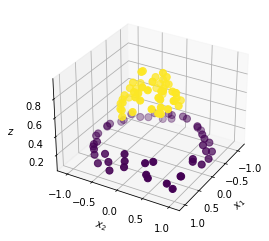

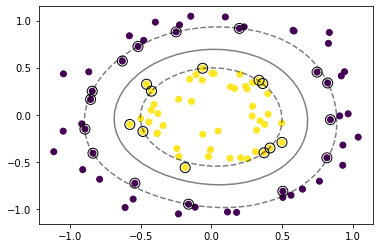

In [14]:
# Example 2:
# Plot the data in a higher-dimensional space.
plot_3D(X=X_circle, y=y_circle, z=rbf(X_circle, np.var(X_circle)))
plt.show()

# Create and fit the non-linear model using the 'rbf' kernel.
non_lin_model_circle = svm.SVC(kernel='rbf')
non_lin_model_circle.fit(X_circle, y_circle)

# Plot the separating hyperplane in the original problem space.
plot_2D(X_circle, y_circle)
plot_2D_svm(non_lin_model_circle)
plt.show()

## 3.3 A closer look at kernels

### Example of kernels
An overview of common kernels:

* **Linear**: $k(x,x') = \langle x, x' \rangle$
* **Polynomial**:  $k(x,x') = \langle x, x' \rangle^{d}, d \in \mathbb{N}$
* **Inhomogeneous Polynomial**: $k(x,x') = \left( \langle x, x' \rangle + c \right)^{d}, d \in \mathbb{N}, 
    c \geq 0$
* **Gaussian**: $k(x, x') = \exp \left( - \frac{\left\lVert x - x' \right\rVert^2}{2 \sigma^2} \right), 
    \sigma > 0$
* **Sigmoid**: $k(x, x') = \tanh \left( \kappa \langle x, x' \rangle + \vartheta \right), \kappa > 0, \vartheta < 0$

These kernels are implemented in the Python module scikit-learn `sklearn.svm` based on the libsvm implementation in C++ by Chih-Chung Chang and Chih-Jen Lin [[Chang, 2011]](#Chang).

### Kernel SVM implementation

In this section we will combine the knowledge we have learned so far and carry out our own implementation of an SVM using kernels. Before we start with the code, we will do a few mathematical transformations on our dual optimization problem in order to be able to process it better later. The optimization problem in ([18](#eq_kernel_dual)) can be re-written by defining a $m \times m $ matrix $Q$ with elements $Q_{ij} = y_i y_i k(x_i, x_j)$ as 

\begin{equation*}
    \begin{aligned}
            \max_{\alpha \in \mathbb{R}^m} \quad & W(\alpha) = \sum_{i=1}^{m} \alpha_i - \frac{1}{2} \alpha^T Q \alpha \\
            \textrm{subject to} \quad & \alpha_i \geq 0 \text{ } \forall i = {1, \dots, m} \text{ and } \sum_{i=1}^{m} 
            \alpha_i y_i = 0. 
    \end{aligned}
\end{equation*}

We continue by defining 

\begin{equation}
    \begin{aligned}
        \Lambda & = 
        \sum_{i=1}^{m} \alpha_i - \frac{1}{2} \alpha^T Q \alpha \\
         & =
        \alpha_\color{red}M + \alpha_\color{blue}L -
        \sum_{j}\alpha_\color{red}M \alpha_j Q_\color{red}M,_j -
        \sum_{i}\alpha_\color{blue}L \alpha_i Q_\color{blue}L,_i + 
        const + 
        \frac{1}{2}\alpha^2_\color{red}M Q_\color{red}M,_\color{red}M + 
        \alpha_\color{red}M\alpha_\color{blue}L Q_\color{red}M,_\color{blue}L +
        \frac{1}{2}\alpha^2_\color{blue}L Q_\color{blue}L,_\color{blue}L \\
        & =
        \alpha_\color{red}M(1-\sum_{j}\alpha_j Q_\color{red}M,_j) + 
        \alpha_\color{blue}L(1-\sum_{i}\alpha_i Q_\color{blue}L,_i) +
        \frac{1}{2}(\alpha^2_\color{red}M Q_\color{red}M,_\color{red}M + 
        2\alpha_\color{red}M\alpha_\color{blue}L Q_\color{red}M,_\color{blue}L +
        \alpha^2_\color{blue}L Q_\color{blue}L,_\color{blue}L) + const \\
        & =
        q^T_0 v_0 + \frac{1}{2}v^2_0 P v_0 + const, 
    \end{aligned}
    \tag{20}
\end{equation}

where 

\begin{equation}
    v_0 = (\alpha_\color{red}M, \alpha_\color{blue}L)^T \tag{21}
\end{equation}

\begin{equation}
    q_0 = (1 - \alpha^T K_\color{red}M, 1 - \alpha^T K_\color{blue}L)^T \tag{22}
\end{equation}

\begin{equation}
    P= \begin{pmatrix}
        Q_\color{red}M,_\color{red}M & Q_\color{red}M,_\color{blue}L \\
        Q_\color{blue}L,_\color{red}M & Q_\color{blue}L,_\color{blue}L
        \end{pmatrix}
        \tag{23}.
\end{equation}

Futhermore

\begin{equation}
    u = (-y_\color{blue}L, y_\color{red}M)^T \tag{24}
\end{equation}


\begin{equation}
    t_n = \frac{q^T_0 u}{u^T P u}. \tag{25}
\end{equation}

With these results we will now implement a python class called `KernelSVM`. In the constructor `__init__` the kernel function `kernel`, the regularization parameter `C` and the maximum solver iterations `max_iteration` are specified. A sequential quadratic programming algorithm is used in the `fit` methode to calculate the $\alpha$ vector. The `restrict_to_square` methode is used in this optimization algorithm as a control for $\alpha$ by an additonal parameter $t$. The bias $b$ can be approximated by $b = \mathbb{E}_{j,\xi_j \neq 0} \left[y_j - \sum_{i}\alpha_i y_i k(x_ix_j) \right]$. The `decision_function` methode is used to calculated the labels of a given input $x$, while `predict` is used to map the labels back to $0$ and $1$, since this is the default in the `sklearn.SVC` class. This is for comparison purposes only.  

In [15]:
class KernelSVM:
    """ 
    Kernel SVM Classifier.
    
    Parameters
    ----------
    kernel : string
        Name the kernel function to be used in the model.
        
    C : float (must be positive)
        Regularization parameter for false classifications.
        
    max_iteration : integer
        Maximum number of solver iterations.
        
    degree : integer
        Degree of the polynomial for polynomial kernels.
        
    gamma : float (must be positive)
        Precision parameters for RBF kernels.
    ----------
    """
    
    def __init__(self, kernel = 'linear', C = 5000.0, max_iteration = 5000, degree = 3, gamma = 1):
        self.kernel = {'poly' : lambda x1,x2: np.dot(x1, x2.T) ** degree,
                       'linear' : lambda x1,x2: np.dot(x1, x2.T),
                       'rbf' : lambda x1,x2: np.exp(-gamma*np.sum((x2-x1[:,np.newaxis])**2,axis=-1))}[kernel]
        self.C = C
        self.max_iteration = max_iteration
        
    def restrict_to_square(self, t, v0, u):
        t = (np.clip(v0 + t*u, 0, self.C) - v0)[1]/u[1]
        return (np.clip(v0 + t*u, 0, self.C) - v0)[0]/u[0]
        
    def fit(self, X, y):
        """ 
        Fitting given data by solving the dual optimization problem 
        to determine the weigths and support vectors. A sequential 
        quadratic programming algorithm is used for the optimization.
        
        Parameters
        ----------
        X : matrix_like
            Matrix with (x1, x2) data points.
            
        y : array_like
            Vector with color labels for individual points.
        ----------
        """
        epsilon = 1e-15
        self.x = X.copy()
        
        # Transformation of the classes 0,1 into -1,+1.
        self.y = y * 2 - 1
        self.alpha = np.zeros_like(self.y, dtype=float)
        
        # Calculation of Q matrix (Gram matrix multiplied by y).
        self.Q = self.kernel(self.x, self.x) * self.y[:,np.newaxis] * self.y
            
        # Sequential quadratic programming.
        for _ in range(self.max_iteration):
            # for all alphas
            for idxM in range(len(self.alpha)):
                # choose random idxL
                idxL = np.random.randint(0, len(self.alpha))
                # count formula (4c)
                P = self.Q[[[idxM, idxM], [idxL, idxL]], [[idxM, idxL], [idxM, idxL]]]
                # count formula (4a)
                v0 = self.alpha[[idxM, idxL]]
                # count formula (4b)
                q0 = 1 - np.sum(self.alpha * self.Q[[idxM, idxL]], axis=1)
                # count formula (4d)
                u = np.array([-self.y[idxL], self.y[idxM]])
                # formula (5) if idxM = idxL
                t_max = np.dot(q0, u) /(np.dot(np.dot(P, u), u) + epsilon)
                self.alpha[[idxM, idxL]] = v0 + u * self.restrict_to_square(t_max, v0, u)
                    
                # Index of support vector.
                idx, = np.nonzero(self.alpha > epsilon)
                
                # Calculate bias value.
                self.b = np.mean((1.0-np.sum(self.Q[idx]*self.alpha,axis=1))*self.y[idx])
                
        # Determine the support vectors. 
        # Epsilon is used as a numerical threshold since alpha can't be equal to zero.
        support_indices = self.alpha > epsilon
        self.support_vectors_ = X[support_indices]
                    
    def decision_function(self, x):
        """ Predict y values in {-1, 1}. """
        return np.sum(self.kernel(x, self.x) * self.y * self.alpha, axis=1) + self.b
        
    def predict(self, x):
        """ Transformation of the classes -1,+1 into 0,1. """ 
        return (np.sign(self.decision_function(x)) + 1) // 2

### Comparison with the scikit learn implementation



In [21]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    non_lin_model_moon_V2 = KernelSVM(kernel="rbf", C=10, max_iteration=200, gamma=1)
    
    training_time = time()
    non_lin_model_moon_V2.fit(X=X_moon, y=y_moon)
    training_time = time() - training_time
    
print(f"Elapsed time for model training: {training_time} seconds.")

Elapsed time for model training: 1.650012731552124 seconds.


Scikit Learn SVM: Number of support vectors: 14
Kernel SVM: Number of support vectors: 14


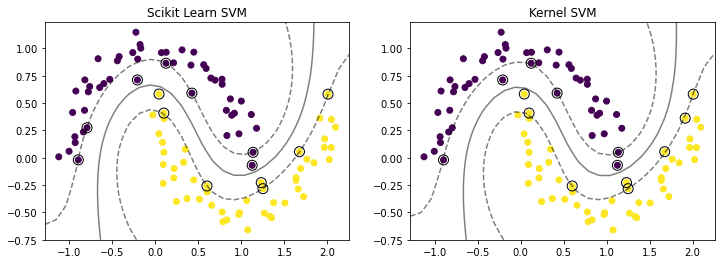

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
plt.subplot(121)
plot_2D(X_moon, y_moon)
plot_2D_svm(non_lin_model_moon)
plt.title("Scikit Learn SVM")

plt.subplot(122)
plot_2D(X_moon, y_moon)
plot_2D_svm(non_lin_model_moon_V2)
plt.title("Kernel SVM")

print(f"Scikit Learn SVM: Number of support vectors: {len(non_lin_model_moon.support_vectors_[:, 0])}")
print(f"Kernel SVM: Number of support vectors: {len(non_lin_model_moon_V2.support_vectors_[:, 0])}")

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    non_lin_model_circle_V2 = KernelSVM(kernel="rbf", C=1, max_iteration=200, gamma=1)
    
    training_time = time()
    non_lin_model_circle_V2.fit(X=X_circle, y=y_circle)
    training_time = time() - training_time
    
print(f"Elapsed time for model training: {training_time} seconds.")

Elapsed time for model training: 1.6747140884399414 seconds.


Scikit Learn SVM: Number of support vectors: 26
Kernel SVM: Number of support vectors: 30


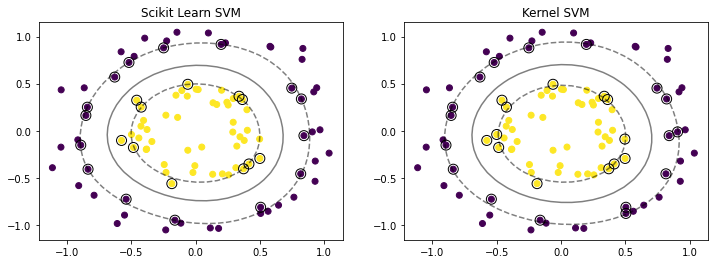

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
plt.subplot(121)
plot_2D(X_circle, y_circle)
plot_2D_svm(non_lin_model_circle)
plt.title("Scikit Learn SVM")

plt.subplot(122)
plot_2D(X_circle, y_circle)
plot_2D_svm(non_lin_model_circle_V2)
plt.title("Kernel SVM")

print(f"Scikit Learn SVM: Number of support vectors: {len(non_lin_model_circle.support_vectors_[:, 0])}")
print(f"Kernel SVM: Number of support vectors: {len(non_lin_model_circle_V2.support_vectors_[:, 0])}")

### Comparison with Quadratic Discriminant Analysis (QDA)

See https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py

In [68]:
def compare_models(X, y, names, classifiers):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

    figure = plt.figure(figsize=(27, 9))
    i = 0

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(141 + i)
    ax.set_title("Input data")
    
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], 100)
    yy = np.linspace(ylim[0], ylim[1], 100)
    YY, XX = np.meshgrid(yy, xx)
    
    i += 1

    for name, clf in zip(names, classifiers):
        ax = plt.subplot(141 + i)
        clf.fit(X_train, y_train)
        
        # Calculate confusion matrix and scores.
        y_predict = clf.predict(X_test)
        conf_mat = metrics.confusion_matrix(y_test, y_predict)
        tp, tn, fp, fn = conf_mat[0,0], conf_mat[1,1], conf_mat[1,0], conf_mat[0,1]
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        sensitivity = tp / (tp + fn)
        specificity = tn / (fp + tn)
        print(f"Model: {name}")
        print(f"Scores: accuracy: {accuracy}, sensitivity: {sensitivity}, specificity: {specificity} \n")

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        ax.contourf(XX, YY, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)

        i += 1

In [42]:
names = ["QDA", "Scikit Learn SVM", "Kernel SVM"]
classifiers = [
    QuadraticDiscriminantAnalysis(),
    svm.SVC(gamma=2, C=1),
    KernelSVM(kernel="rbf", max_iteration=300)
]

Model: QDA
Scores: accuracy: 0.775, sensitivity: 0.65, specificity: 0.9 

Model: Scikit Learn SVM
Scores: accuracy: 0.95, sensitivity: 0.9, specificity: 1.0 



/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: Kernel SVM
Scores: accuracy: 0.975, sensitivity: 0.95, specificity: 1.0 



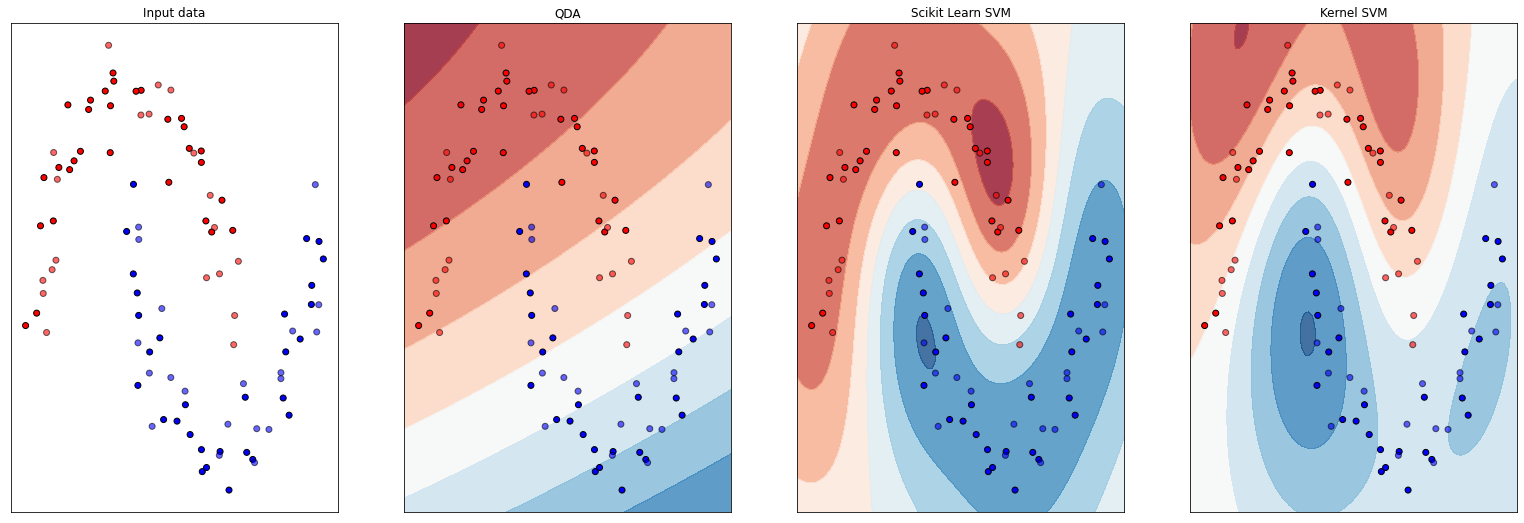

In [70]:
compare_models(X_moon, y_moon, names, classifiers)

Model: QDA
Scores: accuracy: 0.925, sensitivity: 1.0, specificity: 0.8571428571428571 

Model: Scikit Learn SVM
Scores: accuracy: 1.0, sensitivity: 1.0, specificity: 1.0 

Model: Kernel SVM
Scores: accuracy: 1.0, sensitivity: 1.0, specificity: 1.0 



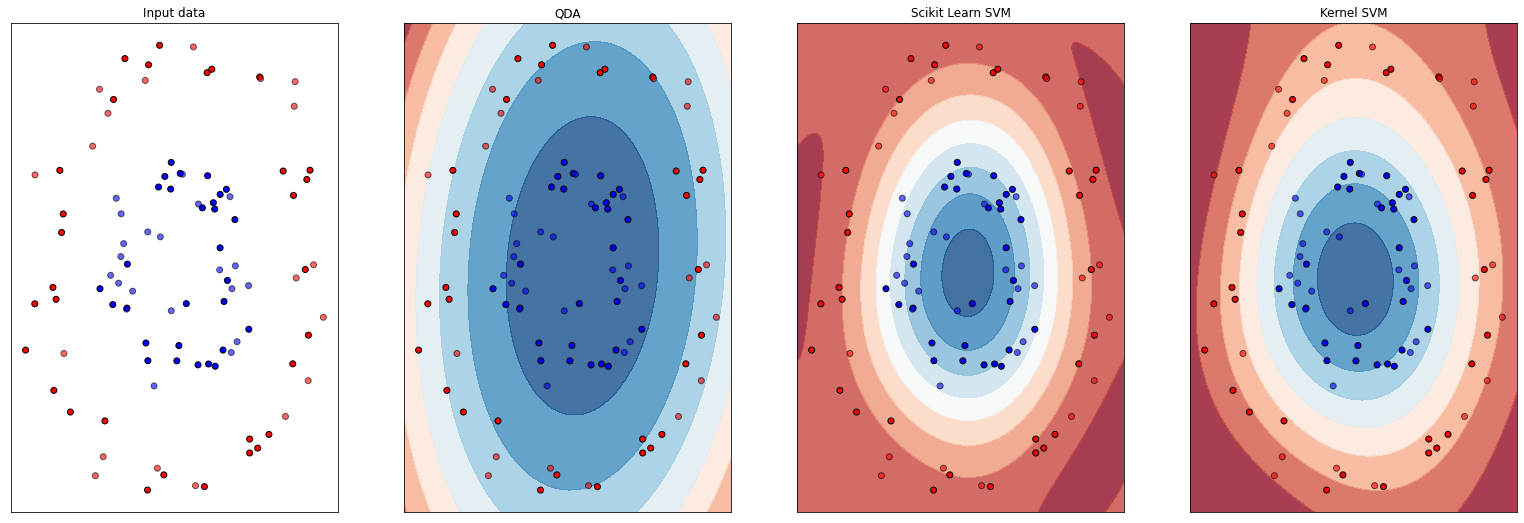

In [71]:
compare_models(X_circle, y_circle, names, classifiers)

You see: kernels are better than QDA.

# 4. More kernel applications
Some interesting kernel applications:
* Image recognition/classification (with SVMs) for example in 
    * Handwriting recognition
    * Tumor detection
* Computer vision and computer graphics, 3D reconstruction
* Kernel principal component analysis

# 5. Conclusion

# References

- <a id="Bronstein">[Bronstein, 2020]</a> Bronstein, Ilja N., et al.: _Taschenbuch der Mathematik._ 11. Auflage, Springer-Verlag, 2020.
- <a id="Chang">[Chang, 2011]</a> Chang, Chih-Chung, Chih-Jen Lin: _LIBSVM : A library for support vector machines._ ACM Transactions on Intelligent Systems and Technology, 2:27:1-27:27, 2011. Software available at https://www.csie.ntu.edu.tw/~cjlin/libsvm/.
- <a id="Jarre">[Jarre, 2019]</a> Jarre, Florian, Josef Stoer: _Optimierung: Einführung in mathematische Theorie und Methoden._ Springer-Verlag, 2019.
- <a id="Liesen">[Liesen, 2015]</a> Liesen, Jörg, Volker Mehrmann: _Lineare Algebra._ Wiesbaden, Germany: Springer, 2015.
- <a id="Reinhardt">[Reinhardt, 2012]</a> Reinhardt, Rüdiger, Armin Ho mann, Tobias Gerlach: _Nichtlineare Optimierung: Theorie, Numerik und Experimente._ Springer-Verlag, 2012.
- <a id="Schölkopf">[Schölkopf, 2002]</a> Schölkopf, Bernhard, Alexander J. Smola: _Learning with Kernels: Support Vector Machines, Regularization, Optimization, and Beyond._ MIT press, 2002.
- <a id="Wikipedia">[Wikipedia, 2021]</a> Wikipedia contributors: _Kernel method_. Wikipedia, The Free Encyclopedia, 11 Jun. 2021. Web. 20 Jun. 2021 at https://en.wikipedia.org/wiki/Kernel_method.